In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import pacf
from scipy import stats, optimize
from statsmodels.tsa.arima.model import ARIMA
import scipy
from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
def autocovariation(dane, h):
    dane_mean = np.mean(dane)
    return 1/len(dane)*sum((dane[i-1]- dane_mean)*(dane[i+h-1]-dane_mean) for i in range(1, len(dane)-h+1))

def autocorelation(dane, h):
    return autocovariation(dane, h)/autocovariation(dane, 0)

In [ ]:
# DLA DEKOMPOZYCJI WALDA
def reglin(X, Y):
    X_mean = np.array(X).mean()
    Y_mean = np.array(Y).mean()

    sum1 = 0
    sum2 = 0

    for i in range(len(X)):
        sum1 += X[i] * (Y[i] - Y_mean)
        sum2 += (X[i] - X_mean) ** 2

    beta1 = sum1 / sum2
    beta0 = Y_mean - beta1 * X_mean
    return [beta1, beta0]

def my_fun(X, param1, param2, param3):
    return param1 * np.sin(param2 * (X-param3))

In [ ]:
raw_data = pd.read_csv('3582667.csv')
raw_data.head()

,NAME,DATE,TAVG
0,"OKECIE, PL",01/01/2012,33
1,"OKECIE, PL",02/01/2012,44
2,"OKECIE, PL",03/01/2012,42
3,"OKECIE, PL",04/01/2012,43
4,"OKECIE, PL",05/01/2012,38


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    3742 non-null   object
 1   DATE    3742 non-null   object
 2   TAVG    3742 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 87.8+ KB


In [ ]:
data = raw_data['DATE'].tolist()
temperatura = raw_data['TAVG'].tolist()
for i in range(len(temperatura)):
  temperatura[i] = (temperatura[i]-32)/1.8

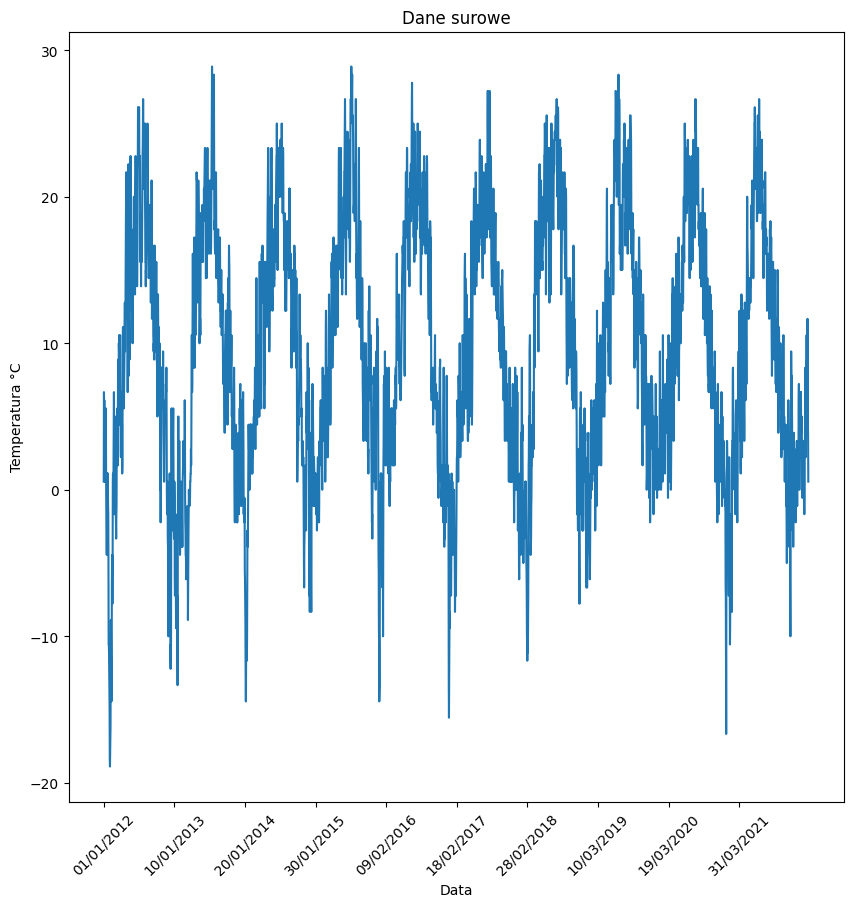

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(len(temperatura)), temperatura)
plt.xticks(range(len(temperatura)), data, rotation = 45)
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Data')
plt.ylabel('Temperatura °C')
plt.title('Dane surowe')
plt.savefig('Dane_surowe');
plt.show()

## Zbiór uczący i testowy

In [ ]:
X_train = data[:3652]
X_test = data[3652:]
Y_train = temperatura[:3652]
Y_test = temperatura[3652:]

## Dane przed dekompozycją

<Figure size 1000x1000 with 0 Axes>

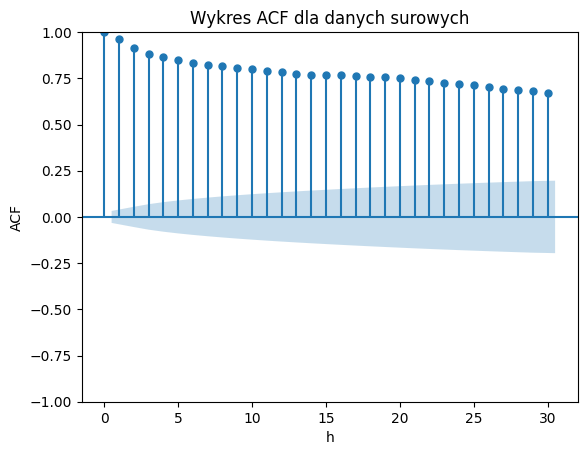

In [ ]:
plt.figure(figsize=(10,10))
plot_acf(Y_train,lags=np.arange(0, 31,1))
plt.xlabel('h')
plt.ylabel('ACF')
plt.title('Wykres ACF dla danych surowych')
plt.savefig('Wykres_ACF_dla_danych_surowych');
plt.show()

<Figure size 1000x1000 with 0 Axes>

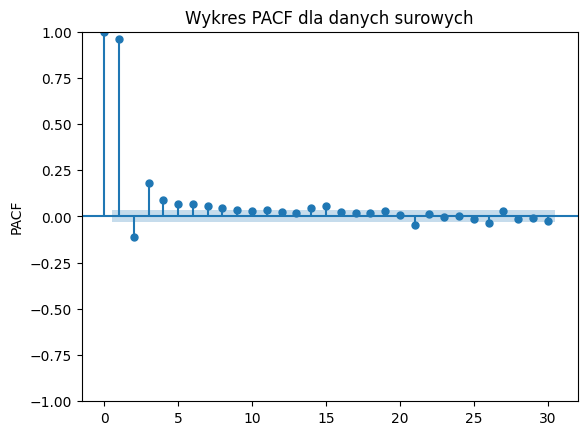

In [ ]:
plt.figure(figsize=(10,10))
plot_pacf(Y_train, lags=np.arange(0, 31,1))
plt.ylabel('PACF')
plt.title('Wykres PACF dla danych surowych')
plt.savefig('Wykres_PACF_dla_danych_surowych');
plt.show()

In [ ]:
adfuller(Y_train)

(-3.8373629049604805,
 0.002547361372905503,
 20,
 3631,
 {'1%': -3.4321522387754775,
  '5%': -2.862336328589075,
  '10%': -2.567193897993964},
 16285.329846310811)

## Dekompozycja

In [ ]:
beta1, beta0 = reglin(range(3652), Y_train)
print(beta0)
print(beta1)

8.88787820153853
0.0005422988280709555


# y = 8.88787820153853 + 0.0005422988280709555*x

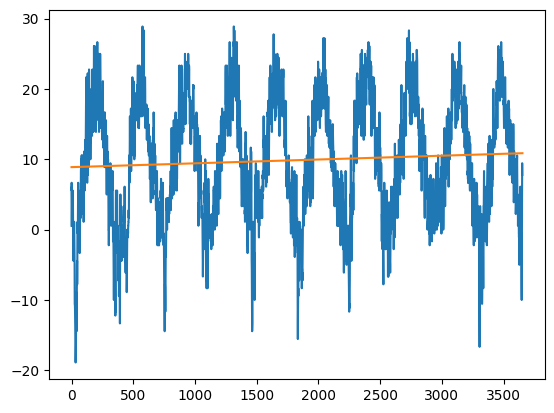

In [ ]:
plt.plot(range(3652), Y_train)
plt.plot([0,3652], [beta0, beta0 + beta1 * 3652])
plt.show()

In [ ]:
Y_train_trend_usunięty = np.array(Y_train) - beta0 - beta1 * np.arange(0,3652)

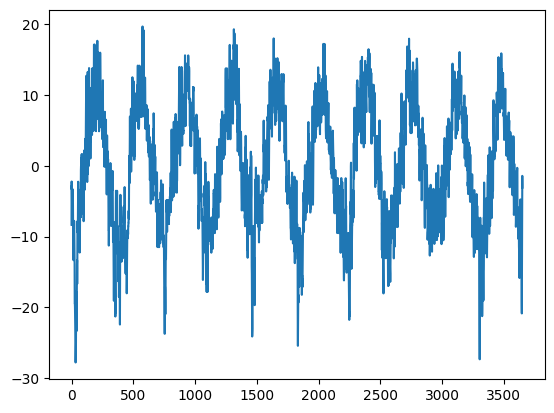

In [ ]:
plt.plot(range(3652), Y_train_trend_usunięty)
plt.show()

In [ ]:
params = optimize.curve_fit(my_fun, range(3652), Y_train_trend_usunięty, p0=[max(Y_train_trend_usunięty), 2 * np.pi /(365), 5])
print(params)

(array([ 1.08007941e+01,  1.72051765e-02, -2.57926572e+02]), array([[ 8.36191062e-03, -1.71212682e-08, -2.08815249e-03],
       [-1.71212682e-08,  6.45956787e-11,  7.88049620e-06],
       [-2.08815249e-03,  7.88049620e-06,  1.20342257e+00]]))


y = 10.8007941 * sin(0.0172051765 * (x+257.926572))

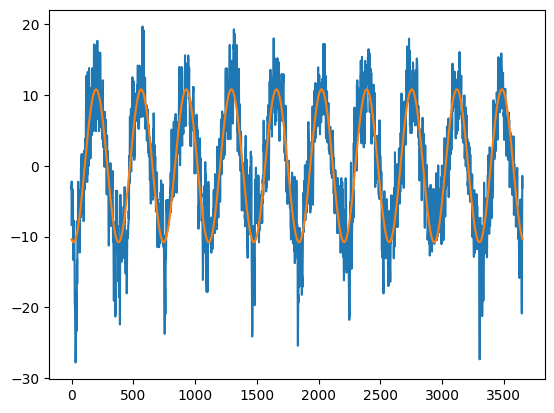

In [ ]:
plt.plot(range(3652), Y_train_trend_usunięty)
plt.plot(range(3652), params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2])))
plt.show()

In [ ]:
Y_train_po_dekompozycji = Y_train_trend_usunięty - params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2]))

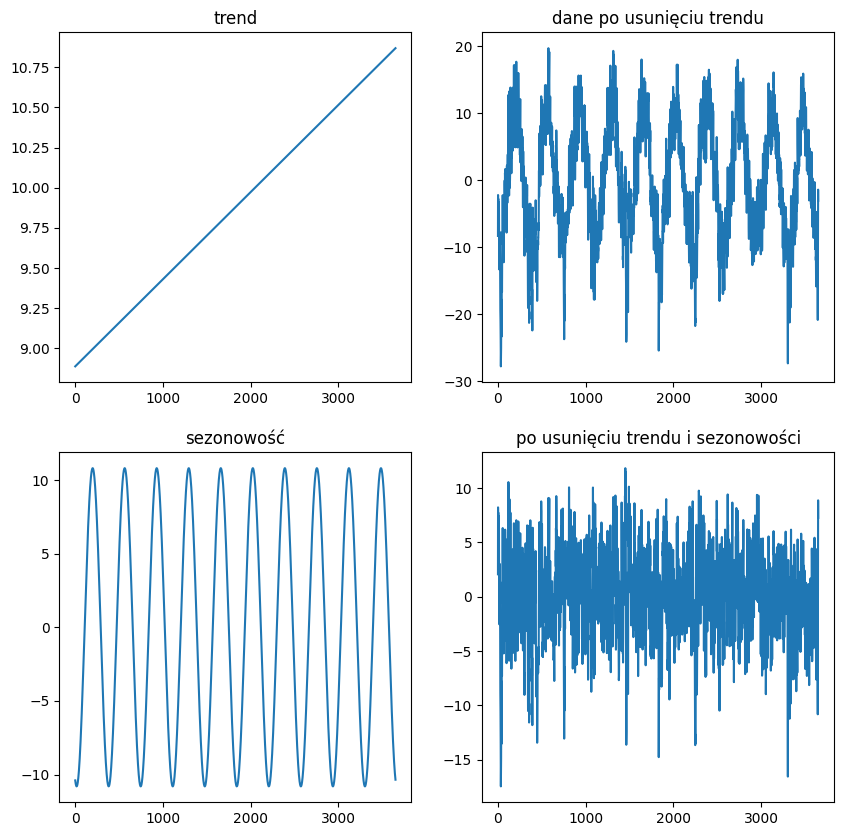

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot([0,3652], [beta0, beta0 + beta1 * 3652])
plt.title("trend")
plt.subplot(2, 2, 2)
plt.plot(range(3652), Y_train_trend_usunięty)
plt.title("dane po usunięciu trendu")
plt.subplot(2, 2, 3)
plt.plot(range(3652), params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2])))
plt.title("sezonowość")
plt.subplot(2, 2, 4)
plt.plot(range(3652), Y_train_po_dekompozycji)
plt.title("po usunięciu trendu i sezonowości")
plt.savefig("Wykresy_usuwania_trendu_i_sezonowosci")
plt.show()

## Dane po dekompozycji

<Figure size 1000x1000 with 0 Axes>

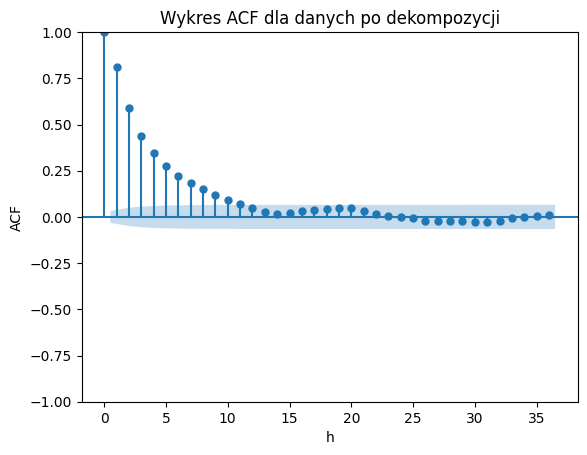

In [ ]:
plt.figure(figsize=(10,10))
plot_acf(Y_train_po_dekompozycji)
plt.xlabel('h')
plt.ylabel('ACF')
plt.title('Wykres ACF dla danych po dekompozycji')
plt.savefig('Wykres_ACF_dla_danych_po_dekompozycj');
plt.show()

<Figure size 1000x1000 with 0 Axes>

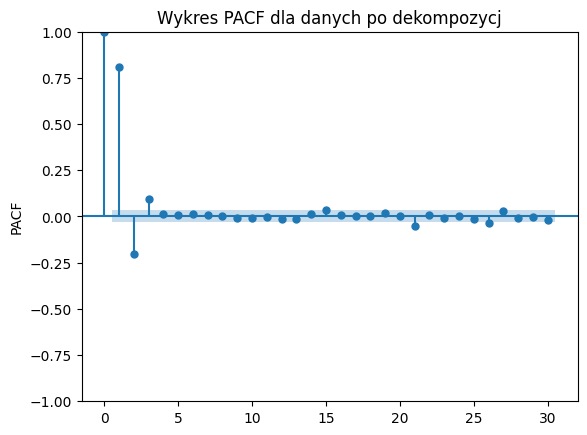

In [ ]:
plt.figure(figsize=(10,10))
plot_pacf(Y_train_po_dekompozycji, lags=np.arange(0, 31,1))
plt.ylabel('PACF')
plt.title('Wykres PACF dla danych po dekompozycj')
plt.savefig('Wykres_PACF_dla_danych_po_dekompozycj');
plt.show()

In [ ]:
adfuller(Y_train_po_dekompozycji)

(-19.424419294854662,
 0.0,
 2,
 3649,
 {'1%': -3.4321433423211882,
  '5%': -2.862332398828442,
  '10%': -2.567191805919415},
 16076.51823917915)

## Dopasowanie modelu ARIMA

In [ ]:
model = ARIMA(Y_train_po_dekompozycji, order=(10, 0, 16)).fit(method='statespace')
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3652
Model:               ARIMA(10, 0, 16)   Log Likelihood               -8087.058
Date:                Tue, 06 Feb 2024   AIC                          16230.117
Time:                        21:07:40   BIC                          16403.802
Sample:                             0   HQIC                         16291.969
                               - 3652                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.191      0.063      0.950      -0.363       0.387
ar.L1          1.0745      1.309      0.821      0.412      -1.490       3.639
ar.L2         -0.5379      1.305     -0.412      0.6

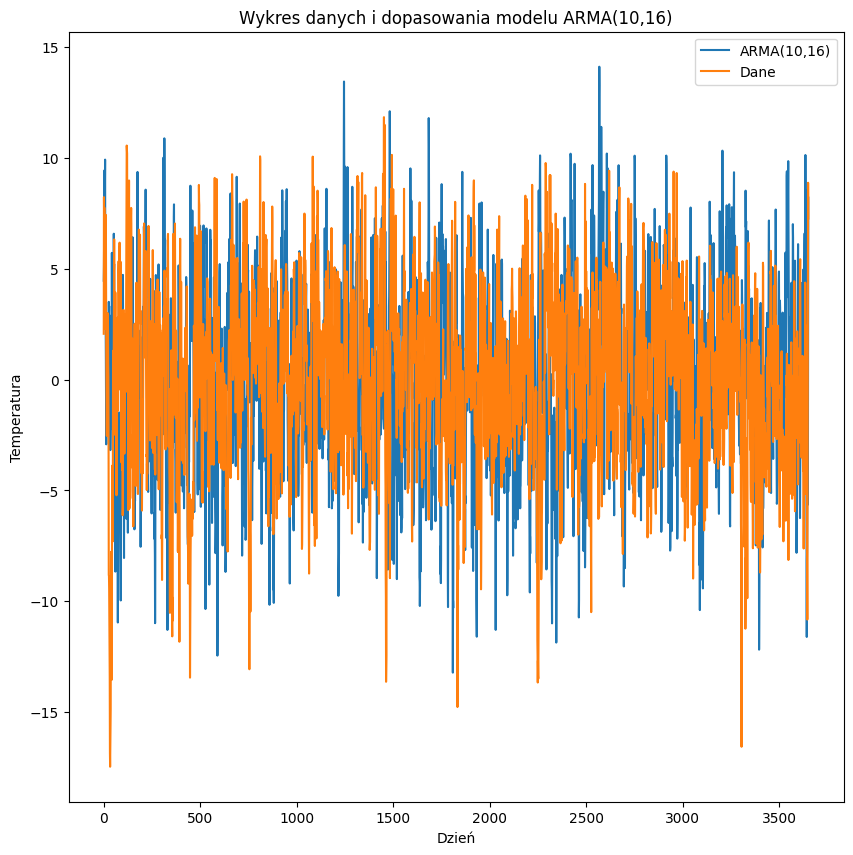

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(3652), model.simulate(3652), label='ARMA(10,16)')
plt.plot(range(3652), Y_train_po_dekompozycji, label='Dane')
plt.xlabel('Dzień')
plt.ylabel('Temperatura')
plt.legend()
plt.title('Wykres danych i dopasowania modelu ARMA(10,16)')
plt.savefig('Wykres_danych_i_dopasowania_modelu_ARMA');
plt.show()

In [ ]:
generowane=model.simulate(3742) + beta0 + beta1 * np.arange(0,3742)+params[0][0] * np.sin(params[0][1] * (range(3742)-params[0][2]))

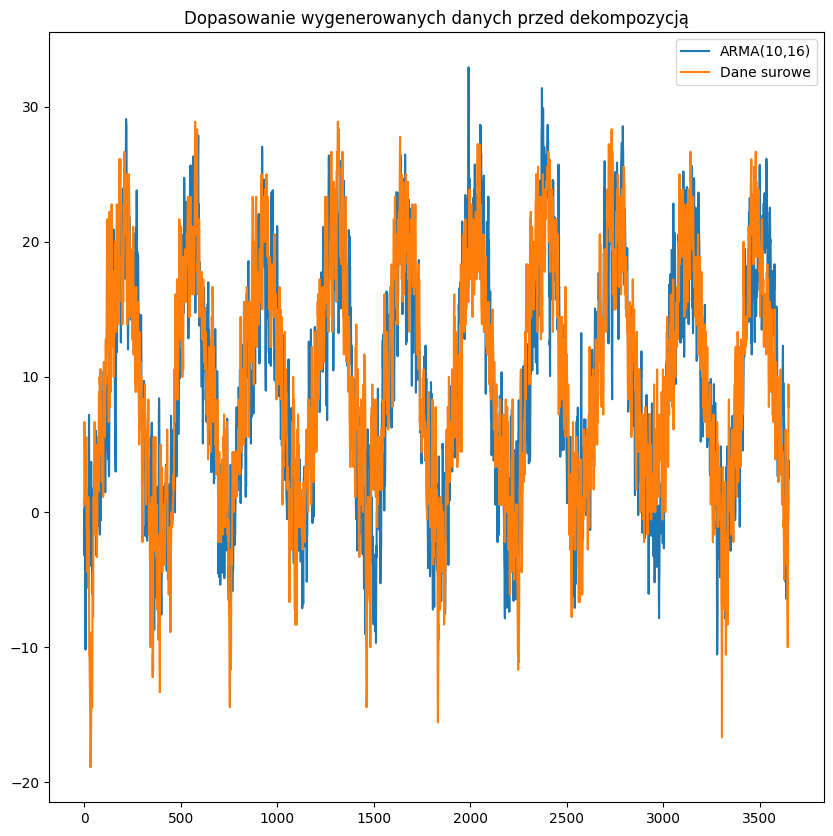

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(generowane[:3652])),generowane[:3652],label="ARMA(10,16)")
plt.plot(np.arange(len(Y_train)),Y_train,label="Dane surowe")
plt.title("Dopasowanie wygenerowanych danych przed dekompozycją")
plt.legend()
plt.savefig('wykres_wygenerowanych_do_treningowych')
plt.show()

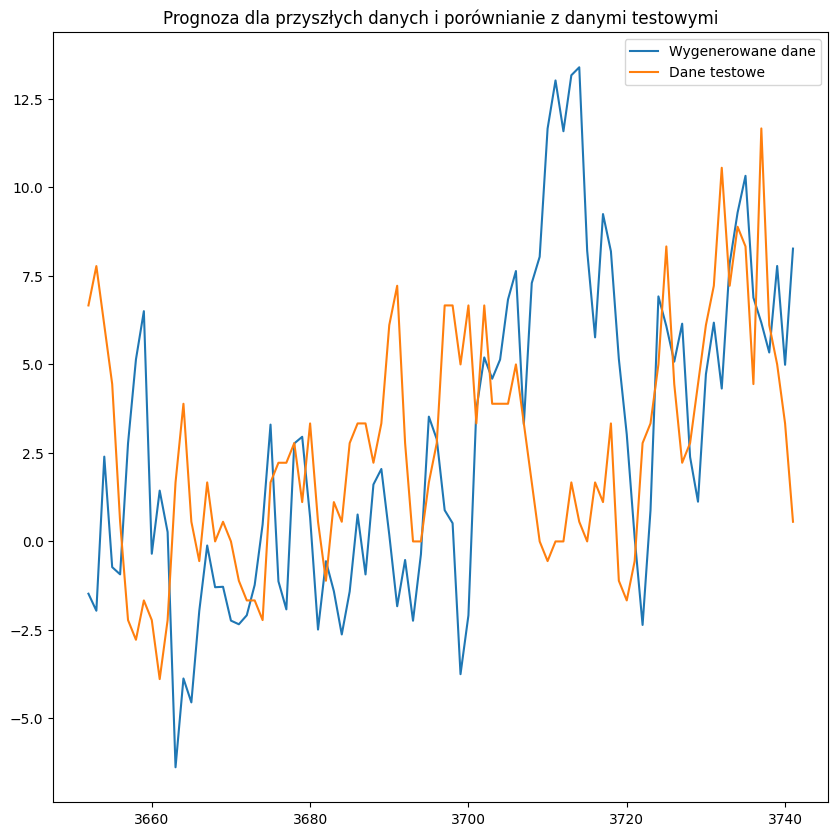

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(3652,3742),generowane[3652:],label="Wygenerowane dane")
plt.plot(np.arange(3652,3742),Y_test,label="Dane testowe")
plt.title("Prognoza dla przyszłych danych i porównianie z danymi testowymi")
plt.legend()
plt.savefig('wykres_prognozowanych_do_testowych')
plt.show()

In [ ]:
print(r2_score(Y_test, [np.mean(Y_test)]*len(Y_test)))

0.0


In [ ]:
generowane=model.simulate(3742) + beta0 + beta1 * np.arange(0,3742)+params[0][0] * np.sin(params[0][1] * (range(3742)-params[0][2]))
print(r2_score(Y_test, generowane[3652:]))
print(mean_absolute_error(Y_test, [np.mean(Y_test)]*len(Y_test)))
print(mean_absolute_percentage_error(Y_test, generowane[3652:]))

-1.323921514688604
2.6049382716049383
1237128804085157.5


In [ ]:
r2_

In [ ]:
alpha=0.05
hs=np.arange(0,31,1)
trajektorie=[]
autokorelacja=[[] for h in hs]
PACF=[]
for i in range(100):
  trajektoria = model.simulate(3742) + beta0 + beta1 * np.arange(0,3742)+params[0][0] * np.sin(params[0][1] * (range(3742)-params[0][2]))
  trajektorie.append(trajektoria)
  for h in hs:
    autokorelacja[h].append(autocorelation(trajektoria,h))

  PACF.append(pacf(trajektoria))


In [ ]:
PACF=np.transpose(PACF)

In [ ]:
gorna_acf= [np.quantile(i,1-alpha) for i in autokorelacja]
dolna_acf= [np.quantile(i,alpha) for i in autokorelacja]
gorna_pacf= [np.quantile(i,1-alpha) for i in PACF]
dolna_pacf= [np.quantile(i,alpha) for i in PACF]

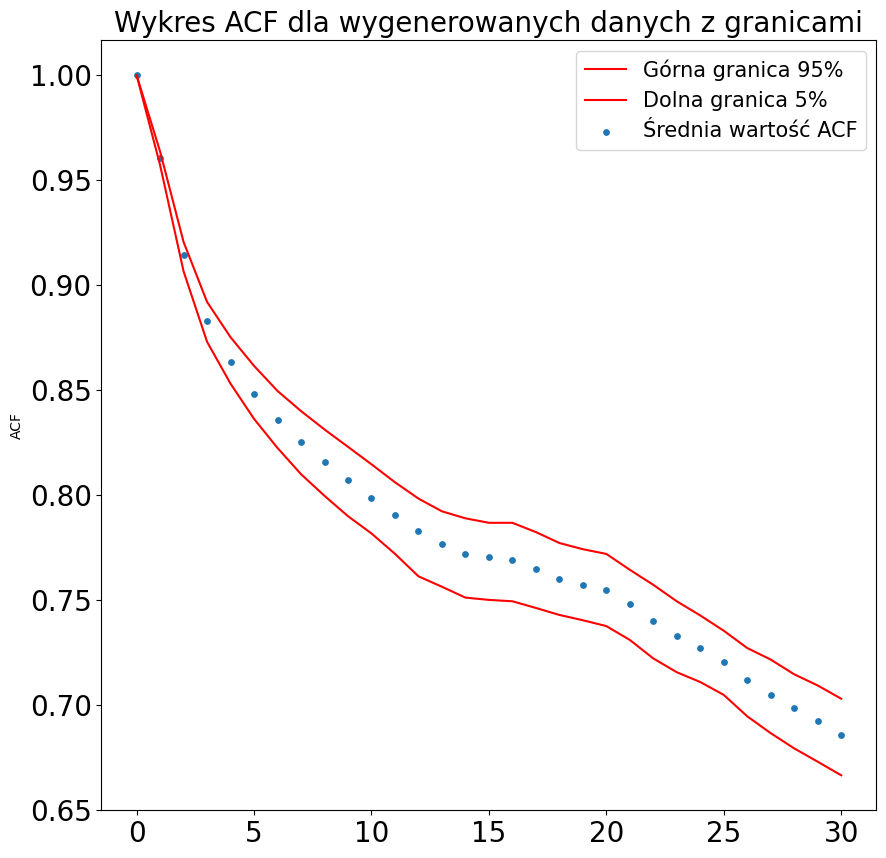

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(hs,gorna_acf,c="r",label="Górna granica 95%")
plt.plot(hs,dolna_acf,c="r",label="Dolna granica 5%")
plt.scatter(hs,[np.mean(autokorelacja[h]) for h in hs],s=15,label="Średnia wartość ACF")
plt.title("Wykres ACF dla wygenerowanych danych z granicami", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('ACF')
plt.legend(fontsize=15)
plt.savefig('wykres_ACF_dla_wygenerowanych')
plt.show()

In [ ]:
PACF = np.transpose(PACF)

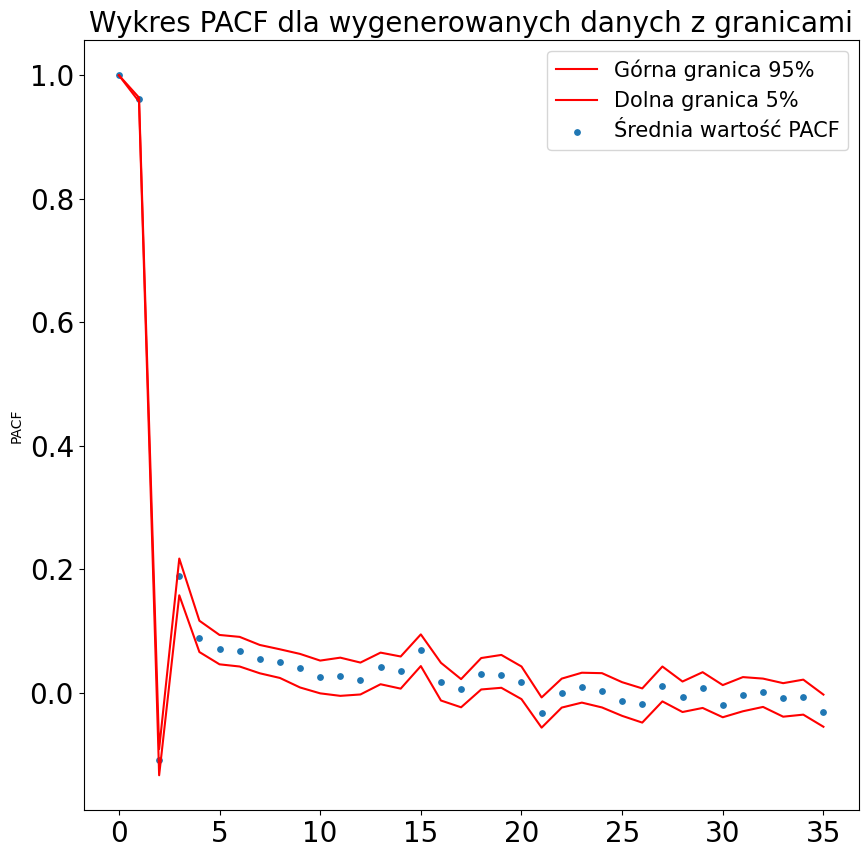

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(36),gorna_pacf,c="r", label="Górna granica 95%")
plt.plot(np.arange(36),dolna_pacf,c="r", label="Dolna granica 5%")
plt.scatter(np.arange(36), [np.mean([PACF[i][j] for i in range(36)]) for j in range(36)],s=15, label="Średnia wartość PACF")
plt.title("Wykres PACF dla wygenerowanych danych z granicami", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('PACF')
plt.legend(fontsize=15)
plt.savefig('wykres_PACF_dla_wygenerowanych')
plt.show()

In [ ]:
trajektorie=[]
for i in range(1000):
  trajektorie.append(model.simulate(3742)+ beta0 + beta1 * np.arange(0,3742)+params[0][0] * np.sin(params[0][1] * (range(3742)-params[0][2])))

In [ ]:
alpha=0.05
gorna_traj= [np.quantile(i,1-alpha) for i in np.transpose(trajektorie)]
dolna_traj= [np.quantile(i,alpha) for i in np.transpose(trajektorie)]

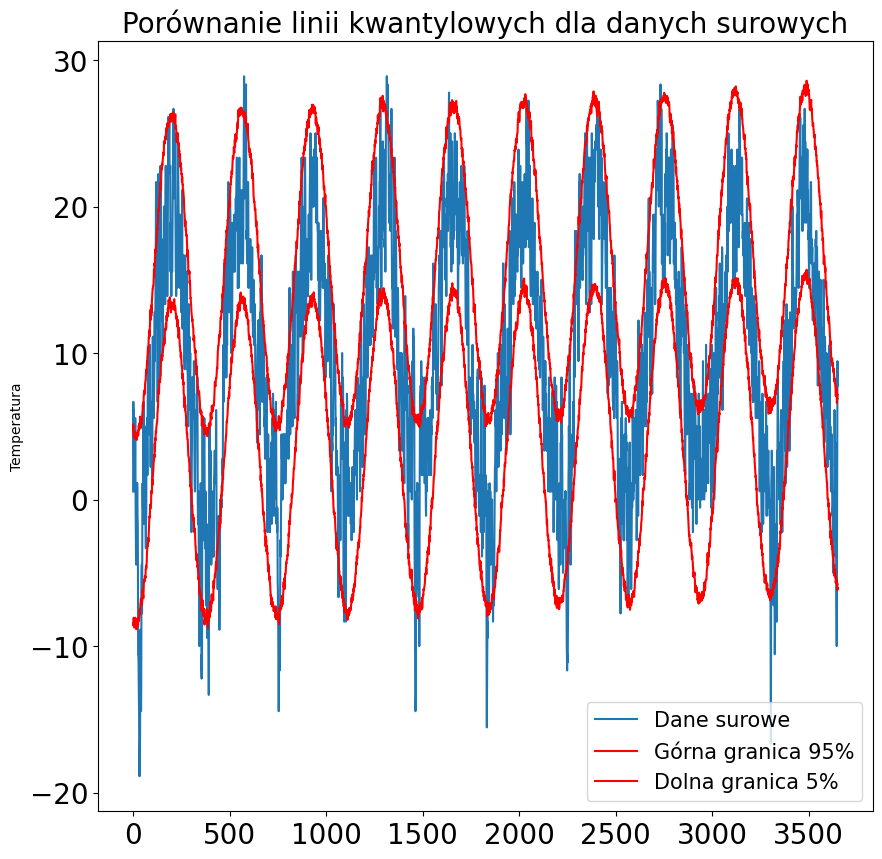

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(3652), Y_train,label="Dane surowe")
plt.plot(np.arange(len(gorna_traj[:3652])),gorna_traj[:3652],label="Górna granica 95%",c="r")
plt.plot(np.arange(len(dolna_traj[:3652])),dolna_traj[:3652],label="Dolna granica 5%",c="r")
plt.title("Porównanie linii kwantylowych dla danych surowych", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Temperatura')
plt.savefig('Linii_kwan_dane_surowe')
plt.show()

In [ ]:
count = 0
for trajektor in trajektorie:
  for i in range(len(trajektor)):
    if trajektor[i] > gorna_traj[i] or trajektor[i] < dolna_traj[i]:
      count += 1
print(count)
print(count/ (len(trajektorie)*len(trajektorie[0])))

374200
0.1


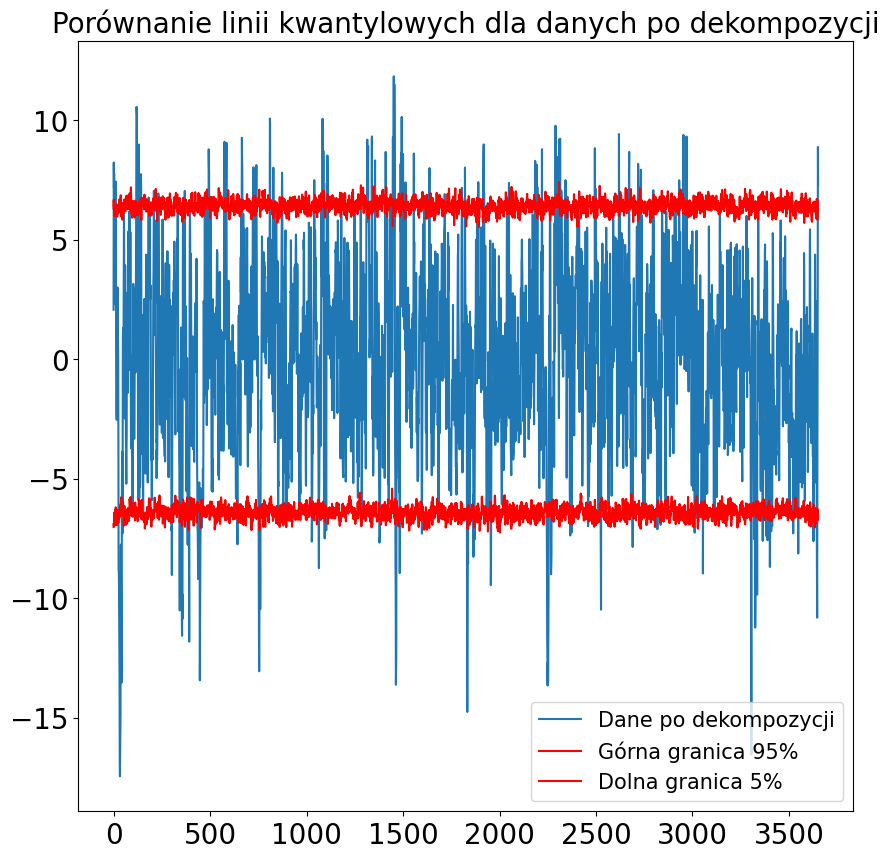

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(3652), Y_train_po_dekompozycji, label='Dane po dekompozycji')
plt.plot(np.arange(len(gorna_traj[:3652])),gorna_traj[:3652]-(beta0 + beta1 * np.arange(0,3652)+params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2]))),label="Górna granica 95%",c="r")
plt.plot(np.arange(len(dolna_traj[:3652])),dolna_traj[:3652]-(beta0 + beta1 * np.arange(0,3652)+params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2]))),label="Dolna granica 5%",c="r")
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Porównanie linii kwantylowych dla danych po dekompozycji", fontsize=20)
plt.savefig('Linii_kwan_dane_po_dekom')
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(range(3652), Y_train,label="dane")
plt.plot(np.arange(len(gorna_traj[:3652])),gorna_traj[:3652],label="gorna granica",c="r")
plt.plot(np.arange(len(dolna_traj[:3652])),dolna_traj[:3652],label="dolna granica",c="r")
plt.title("Porównanie lini kwantylowych")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(3652), Y_train_po_dekompozycji, label='Dane po dekompozycji')
plt.plot(np.arange(len(gorna_traj[:3652])),gorna_traj[:3652]-(beta0 + beta1 * np.arange(0,3652)+params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2]))),label="gorna granica",c="r")
plt.plot(np.arange(len(dolna_traj[:3652])),dolna_traj[:3652]-(beta0 + beta1 * np.arange(0,3652)+params[0][0] * np.sin(params[0][1] * (range(3652)-params[0][2]))),label="dolna granica",c="r")
plt.legend()
plt.title("dla alpha=0.05 z danymi")
plt.savefig('wykres_lini_kwantylowych_z_danymi')
plt.show()

In [ ]:
len(Y_test)

90

In [ ]:
len(np.arange(3653, 3653 + len(Y_test),1))

90

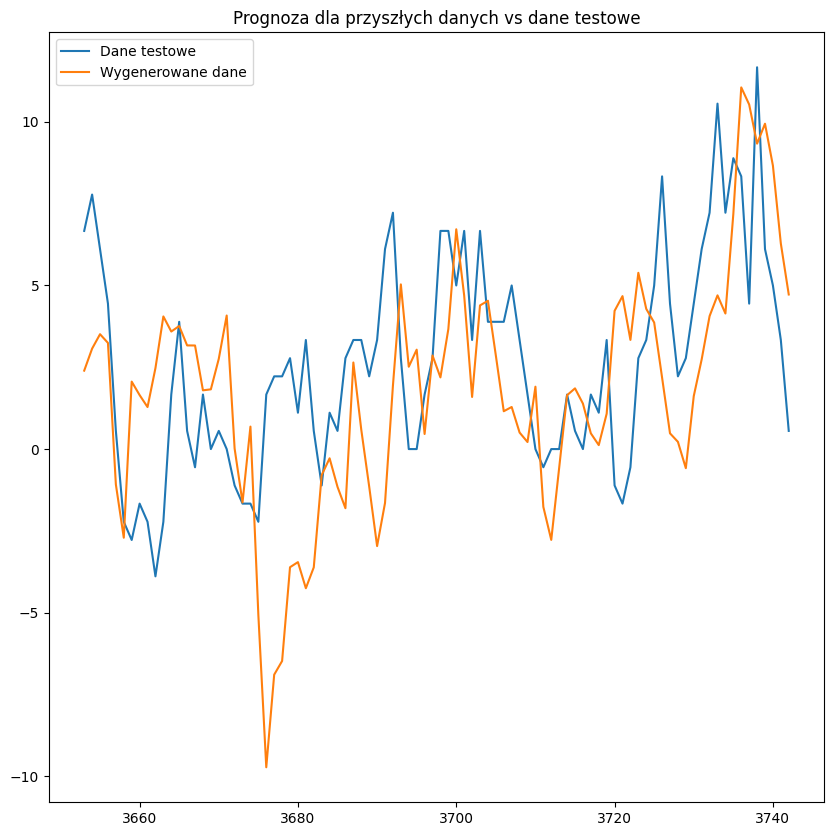

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(3653, 3653 + len(Y_test),1),Y_test, label='Dane testowe')
plt.plot(np.arange(3653, 3653 + len(Y_test),1), generowane[3652:], label='Wygenerowane dane')
plt.legend()
plt.title("Prognoza dla przyszłych danych vs dane testowe")
plt.savefig('prognoza')
plt.show()

In [ ]:
szum=Y_train-generowane[:3652]

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(szum)),szum,label="wygenerowany szum")
plt.title("Wykres wartości resztowych")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(szum[:100])),szum[:100],label="wygenerowane dane")
plt.title("Wykres wartości resztowych na przedziale [0,100]")

plt.savefig('wykres_wartosci_resztowych')
plt.show()

In [ ]:
np.mean(szum)

In [ ]:
np.var(szum)

In [ ]:
plt.figure(figsize=(10,10))
plot_acf(szum)
plt.savefig("Wykres_ACF_dla_szumu")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plot_pacf(szum)
plt.savefig("Wykres_PACF_dla_szumu")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(szum,label="estymowane dane")
plt.plot(np.linspace(-25,25,1000),scipy.stats.norm.pdf(np.linspace(-25,25,1000),np.mean(szum),np.sqrt(np.var(szum))),label=f'$N({np.mean(szum):.2f},{np.sqrt(np.var(szum)):.2f})$')
plt.title('Wykres gęstości rozkładu normalnego z estymatorem jądrowym gęstości', fontsize=13, fontweight='bold')
plt.legend()
plt.savefig('Wykres_gestosci')
plt.show()

In [ ]:
scipy.stats.kstest(szum,np.random.normal(np.mean(szum),np.sqrt(np.var(szum)),500))

In [ ]:
szum=model.resid

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(szum)),szum,label="wygenerowany szum")
plt.title("Wykres wartości resztowych")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(szum[:100])),szum[:100],label="wygenerowane dane")
plt.title("Wykres wartości resztowych na przedziale [0,100]")

plt.savefig('wykres_wartosci_resztowych')
plt.show()

In [ ]:
np.mean(szum)

In [ ]:
np.var(szum)

In [ ]:
plt.figure(figsize=(10,10))
plot_acf(szum)
plt.savefig("Wykres_ACF_dla_szumu")
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plot_pacf(szum)
plt.savefig("Wykres_PACF_dla_szumu")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(szum,label="estymowane dane")
plt.plot(np.linspace(-25,25,1000),scipy.stats.norm.pdf(np.linspace(-25,25,1000),np.mean(szum),np.sqrt(np.var(szum))),label=f'$N({np.mean(szum):.2f},{np.sqrt(np.var(szum)):.2f})$')
plt.title('Wykres gęstości rozkładu normalnego z estymatorem jądrowym gęstości', fontsize=13, fontweight='bold')
plt.legend()
plt.savefig('Wykres_gestosci')
plt.show()

In [ ]:
scipy.stats.kstest(szum,np.random.normal(np.mean(szum),np.sqrt(np.var(szum)),500))